<a href="https://colab.research.google.com/github/Zoro114/mne/blob/main/Continous_target_decoding_with_SPOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 5.2 MB/s 


In [5]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import Epochs
from mne.decoding import SPoC
from mne.datasets.fieldtrip_cmc import data_path

from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_predict

In [7]:
fname=data_path()/'SubjectCMC.ds'
raw=mne.io.read_raw_ctf(fname)
raw.crop(50,200)

ds directory : /root/mne_data/MNE-fieldtrip_cmc-data/SubjectCMC.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       0.33   78.32    0.00 mm <->    0.33   78.32    0.00 mm (orig :  -71.62   40.46 -256.48 mm) diff =    0.000 mm
      -0.33  -78.32   -0.00 mm <->   -0.33  -78.32   -0.00 mm (orig :   39.27  -70.16 -258.60 mm) diff =    0.000 mm
     114.65    0.00   -0.00 mm <->  114.65    0.00    0.00 mm (orig :   64.35   66.64 -262.01 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 4 EEG channels from channel info
    4 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /root/mne_data/MNE-fieldtrip_cmc-data/SubjectCMC.ds/SubjectCMC.meg4: 
    System clock channel is available, checking which samples are valid.
    75 x 12000 

<RawCTF | SubjectCMC.meg4, 191 x 180001 (150.0 s), ~341 kB, data not loaded>

In [8]:
emg=raw.copy().pick_channels(['EMGlft']).load_data()
emg.filter(20,None)

Reading 0 ... 180000  =      0.000 ...   150.000 secs...
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 20.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 17.50 Hz)
- Filter length: 793 samples (0.661 sec)



<RawCTF | SubjectCMC.meg4, 1 x 180001 (150.0 s), ~1.4 MB, data loaded>

In [10]:
raw.pick_types(meg=True,ref_meg=True,eeg=False,eog=False).load_data()
raw.filter(15,30)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1057 samples (0.881 sec)



<RawCTF | SubjectCMC.meg4, 183 x 180001 (150.0 s), ~251.6 MB, data loaded>

In [11]:
events=mne.make_fixed_length_events(raw,id=1,duration=0.75)

In [12]:
meg_epochs=mne.Epochs(raw,events,tmin=0,tmax=1.5,baseline=None,detrend=1,decim=20)
emg_epochs=mne.Epochs(emg,events,tmin=0,tmax=1.5,baseline=None)

Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated


<ipython-input-12-9c078426a240>:1: RuntimeWarning: The measurement information indicates a low-pass frequency of 30 Hz. The decim=20 parameter will result in a sampling frequency of 60 Hz, which can cause aliasing artifacts.
  meg_epochs=mne.Epochs(raw,events,tmin=0,tmax=1.5,baseline=None,detrend=1,decim=20)


In [13]:
X=meg_epochs.get_data()
y=emg_epochs.get_data().var(axis=2)[:,0]

Using data from preloaded Raw for 200 events and 1801 original time points (prior to decimation) ...
1 bad epochs dropped
Using data from preloaded Raw for 200 events and 1801 original time points ...
1 bad epochs dropped


In [15]:
spoc=SPoC(n_components=2,log=True,reg='oas',rank='full')
clf=make_pipeline(spoc,Ridge())
cv=KFold(n_splits=2,shuffle=False)

In [16]:
y_pred=cross_val_predict(clf,X,y,cv=cv)

Computing rank from data with rank='full'
    MAG: rank 183 from info
Reducing data rank from 183 -> 183
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 183 from info
Reducing data rank from 183 -> 183
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 183 from info
Reducing data rank from 183 -> 183
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 183 from info
Reducing data rank from 183 -> 183
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 183 from info
Reducing data rank from 183 -> 183
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 183 from info
Reducing data rank from 183 -> 183
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 183 from info
Reducing data rank from 183 -> 183
Estimating covariance using OAS
Done.

In [19]:
times=raw.times[meg_epochs.events[:,0]-raw.first_samp]

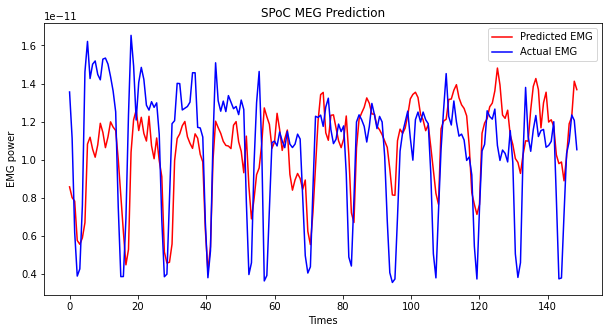

In [35]:
fig,ax=plt.subplots(figsize=[10,5])
ax.plot(times,y_pred,color='r',label='Predicted EMG')
ax.plot(times,y,color='b',label='Actual EMG')
ax.set_xlabel('Times')
ax.set_ylabel('EMG power')
ax.set_title('SPoC MEG Prediction')
ax.legend()

In [36]:
spoc.fit(X,y)

Computing rank from data with rank='full'
    MAG: rank 183 from info
Reducing data rank from 183 -> 183
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 183 from info
Reducing data rank from 183 -> 183
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 183 from info
Reducing data rank from 183 -> 183
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 183 from info
Reducing data rank from 183 -> 183
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 183 from info
Reducing data rank from 183 -> 183
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 183 from info
Reducing data rank from 183 -> 183
Estimating covariance using OAS
Done.
Computing rank from data with rank='full'
    MAG: rank 183 from info
Reducing data rank from 183 -> 183
Estimating covariance using OAS
Done.

SPoC(cov_method_params=None, log=True, n_components=2, rank='full', reg='oas',
   transform_into='average_power')

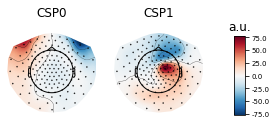

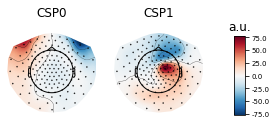

In [37]:
spoc.plot_patterns(meg_epochs.info)